In [1]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
# import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
# tf.random.set_seed(42)  
# tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)



In [2]:
from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names

2022-09-11 09:17:22.711757: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data()

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print(reduced_labels)



Components :  [[0 1 2 3 4 5]]
Components shape :  (1, 6)
['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']


In [4]:
data_filename = "datasets/TSMCN-5-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.05_10-09-2022_time_19-52-15.pkl"
DV = pd.read_pickle(data_filename)
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4'],axis=1).to_numpy()

In [5]:


print('X shape:', X.shape)
print('y_concentrations shape:', y_concentrations.shape)

print('X dtype:', X.dtype)
print('y_concentrations dtype:', y_concentrations.dtype)

X=X.astype(np.float)
y_concentrations=y_concentrations.astype(np.float)

print('After data type conversion')
print('X dtype:', X.dtype)
print('y_concentrations dtype:', y_concentrations.dtype)




X shape: (62000, 229)
y_concentrations shape: (62000, 5)
X dtype: float64
y_concentrations dtype: object
After data type conversion
X dtype: float64
y_concentrations dtype: float64


/tmp/ipykernel_27943/1241194083.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X=X.astype(np.float)
/tmp/ipykernel_27943/1241194083.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_concentrations=y_concentrations.astype(np.float)


In [8]:
y_ohe = concentrations_to_one_hot_encode(y_concentrations)

In [9]:
mixture_names= []
for _ in range(y_ohe.shape[0]):
    mixture_names.append(create_mixture_names(y_ohe[_],m.n_mixture_component_max,reduced_labels))

    
# for _ in range(y_ohe.shape[0]):
#     print(mixture_names[_])

In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)
y = le.transform(mixture_names)

# le.inverse_transform(y)
mixture_types=le.classes_
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$+$HNO_3$'
 '$CH_3CHO$+$CH_3OH$' '$CH_3CHO$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$HNO_3$'
 '$CH_3CN$' '$CH_3CN$+$CH_3OH$' '$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CN$+$HNO_3$' '$CH_3Cl$' '$CH_3Cl$+$CH_3CN$'
 '$CH_3Cl$+$CH_3CN$+$CH_3OH$' '$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3Cl$+$CH_3CN$+$HNO_3$' '$CH_3Cl$+$CH_3OH$'
 '$CH_3Cl$+$CH_3OH$+$HNO_3$' '$CH_3Cl$+$HNO_3$' '$CH_3OH$'
 '$CH_3OH$+$HNO_3$' '$HNO_3$']


In [11]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
VAL_SIZE=1-TRAIN_SIZE

x_train, x_val, y_train, y_val, train_indices, val_indices = train_test_split(X, y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=VAL_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_val shape:', x_val.shape)
print('y_ohe_val shape:', y_val.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Validation:", np.bincount(y_val) / float(len(y_val))*100  )


range(0, 62000)
X_train shape: (37200, 229)
y_ohe_train shape: (37200,)
X_val shape: (24800, 229)
y_ohe_val shape: (24800,)
All: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Training: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Validation: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580

In [12]:
y_train_ohe = y_concentrations[train_indices].astype('int64')
y_val_ohe = y_concentrations[val_indices].astype('int64')

In [13]:
y_ohe = concentrations_to_one_hot_encode(y_concentrations).astype('int64')

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold


from sklearn import svm
from sklearn.svm import SVC

In [15]:
x_train.shape

(37200, 229)

In [16]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
clf = MultiOutputClassifier(LogisticRegression()).fit(x_train, y_train_ohe)
clf_SVC = MultiOutputClassifier(SVC()).fit(x_train, y_train_ohe)


# clf = MultiOutputClassifier(SVC(kernel='linear',C = 500,decision_function_shape = 'ovo',random_state=1)).fit(X, y)

In [17]:
x_val[0].shape

(229,)

In [18]:
y_pred_ohe = clf.predict(x_val)
y_pred_ohe_SVC = clf_SVC.predict(x_val)

In [19]:

# for idx in range(0, y_val_ohe.shape[0]):
#     print('predicted', y_pred_ohe[idx])
#     print('validation', y_val_ohe[idx])

In [20]:
# from sklearn.multioutput import ClassifierChain

# base_lr = LogisticRegression(solver='lbfgs', random_state=0)
# chain = ClassifierChain(base_lr, order='random', random_state=0)
# chain.fit(x_train, y_train_ohe).predict(x_val)



# chain.predict_proba(x_val)


In [21]:
from sklearn.metrics import multilabel_confusion_matrix

In [22]:
multilabel_confusion_matrix(y_val_ohe, y_pred_ohe)

array([[[12000,     0],
        [  308, 12492]],

       [[12000,     0],
        [  452, 12348]],

       [[12000,     0],
        [  414, 12386]],

       [[12000,     0],
        [   81, 12719]],

       [[12000,     0],
        [  365, 12435]]])

In [23]:
multilabel_confusion_matrix(y_val_ohe, y_pred_ohe_SVC)

array([[[12000,     0],
        [   31, 12769]],

       [[12000,     0],
        [  150, 12650]],

       [[12000,     0],
        [  121, 12679]],

       [[12000,     0],
        [    0, 12800]],

       [[12000,     0],
        [   60, 12740]]])

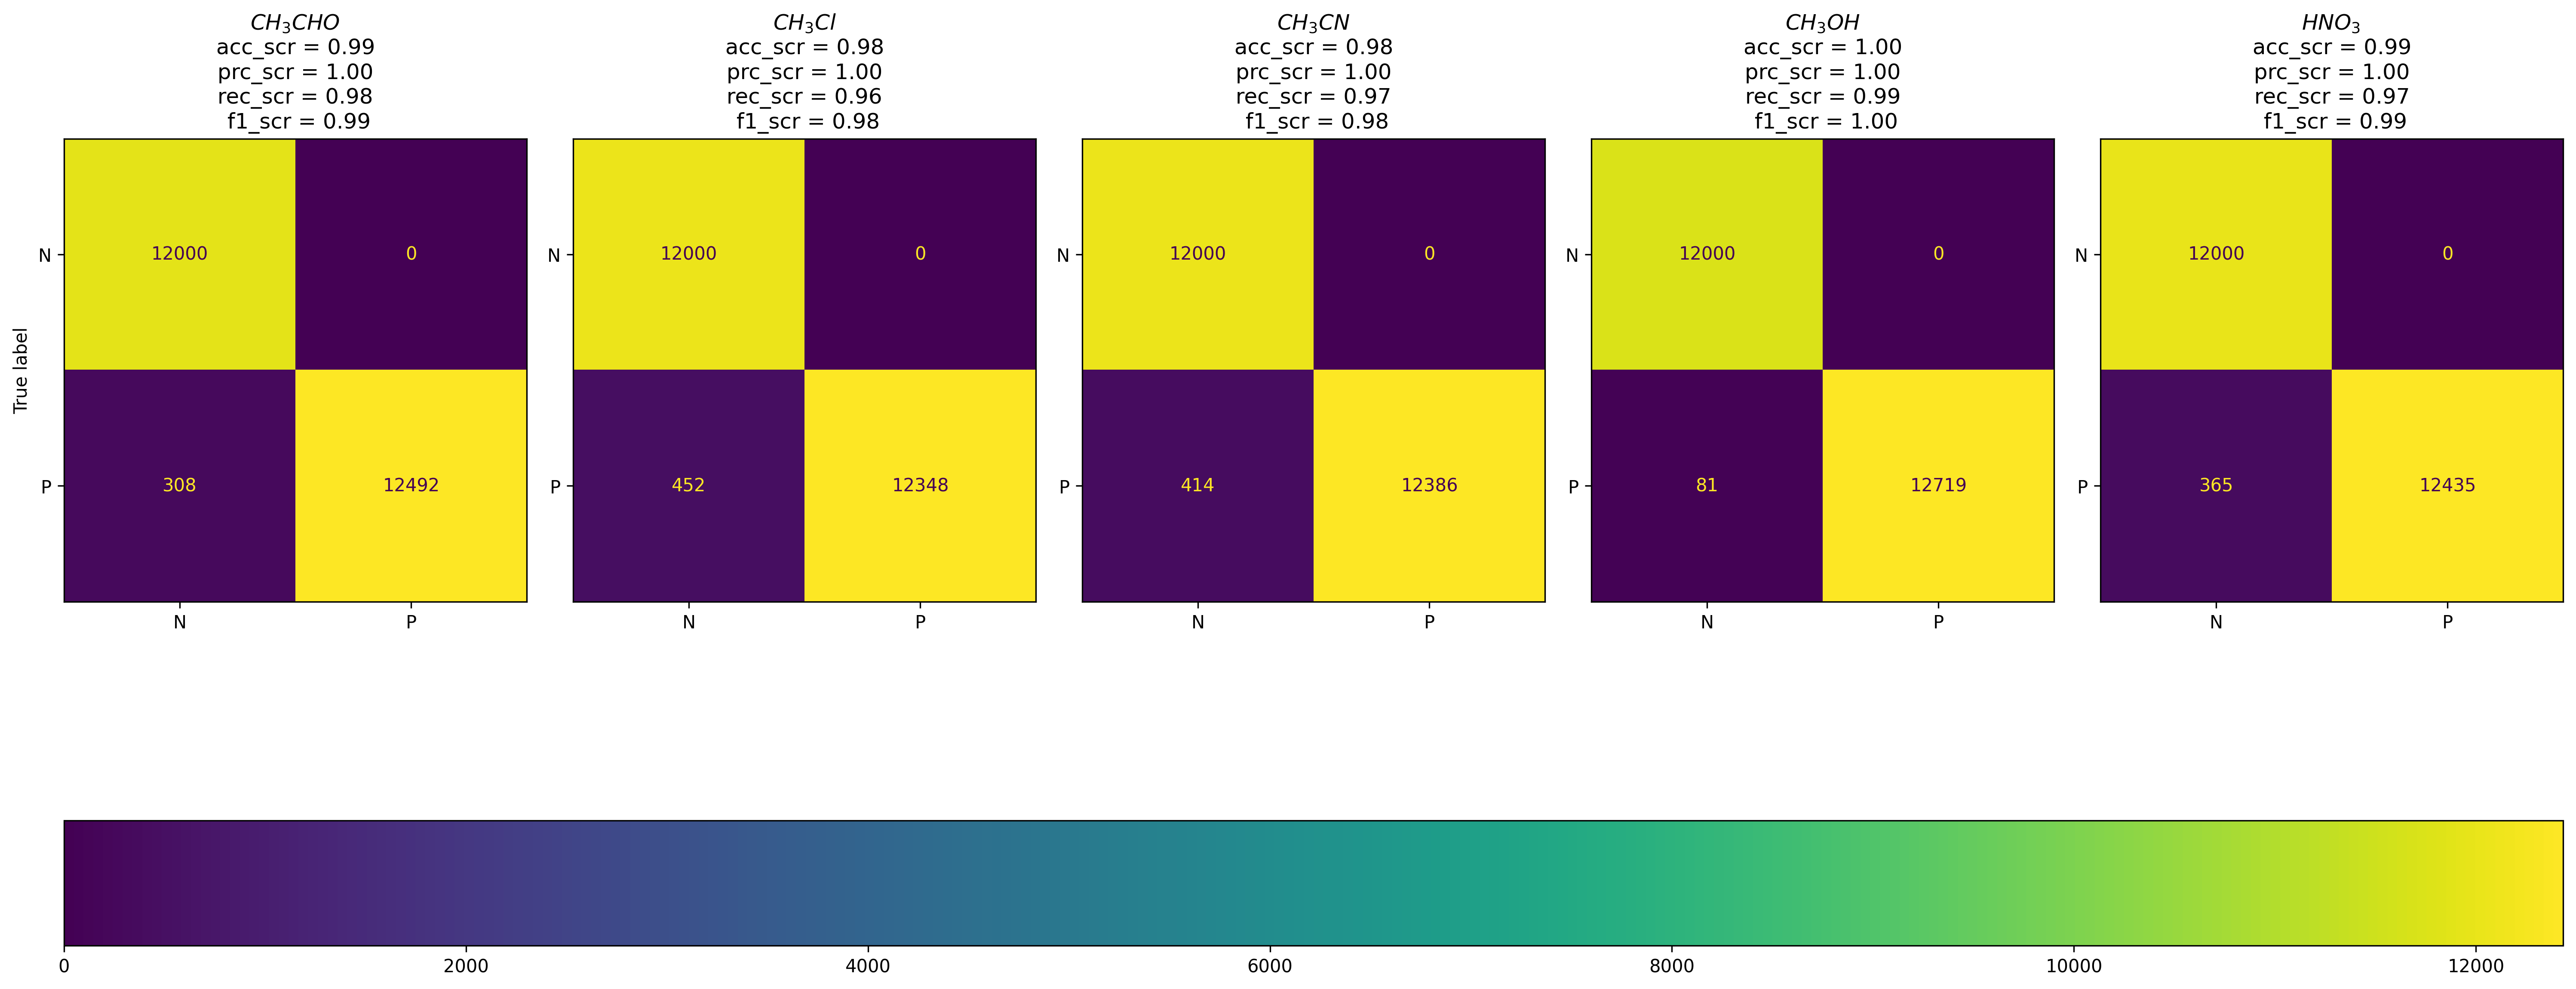

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import make_multilabel_classification
# from sklearn.tree import DecisionTreeClassifier

# X, y = make_multilabel_classification(n_samples=1000,
#                                       n_classes=15, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=42)

# tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# y_pred = tree.predict(X_test)

f, axes = plt.subplots(1, 5, figsize=(25, 15), dpi=300)
axes = axes.ravel()
for i in range(5):
    acc_scr = accuracy_score(y_val_ohe[:, i], y_pred_ohe[:, i])
    prc_scr = precision_score(y_val_ohe[:, i], y_pred_ohe[:, i])
    rec_scr = recall_score(y_val_ohe[:, i], y_pred_ohe[:, i])
    f1_scr = f1_score(y_val_ohe[:, i], y_pred_ohe[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix(y_val_ohe[:, i],
                                                   y_pred_ohe[:, i]),
                                  display_labels=['N', 'P'])

#     disp = ConfusionMatrixDisplay.from_predictions(y_val_ohe[:, i],
#                                                    y_pred_ohe[:, i], cmap = 'Blues',
#                                   display_labels=['N', 'P'])
    
    disp.plot(ax=axes[i])
#     disp.plot(ax=axes[i], values_format='.4g'
    disp.ax_.set_title(f'{reduced_labels[i]} \n acc_scr = {acc_scr:.2f} \n prc_scr = {prc_scr:.2f} \n rec_scr = {rec_scr:.2f} \n f1_scr = {f1_scr:.2f}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, orientation = 'horizontal')
plt.show()
f.savefig(r'RESULTS/multi_label_results/multilabel_cm_bin_val.png', bbox_inches='tight')

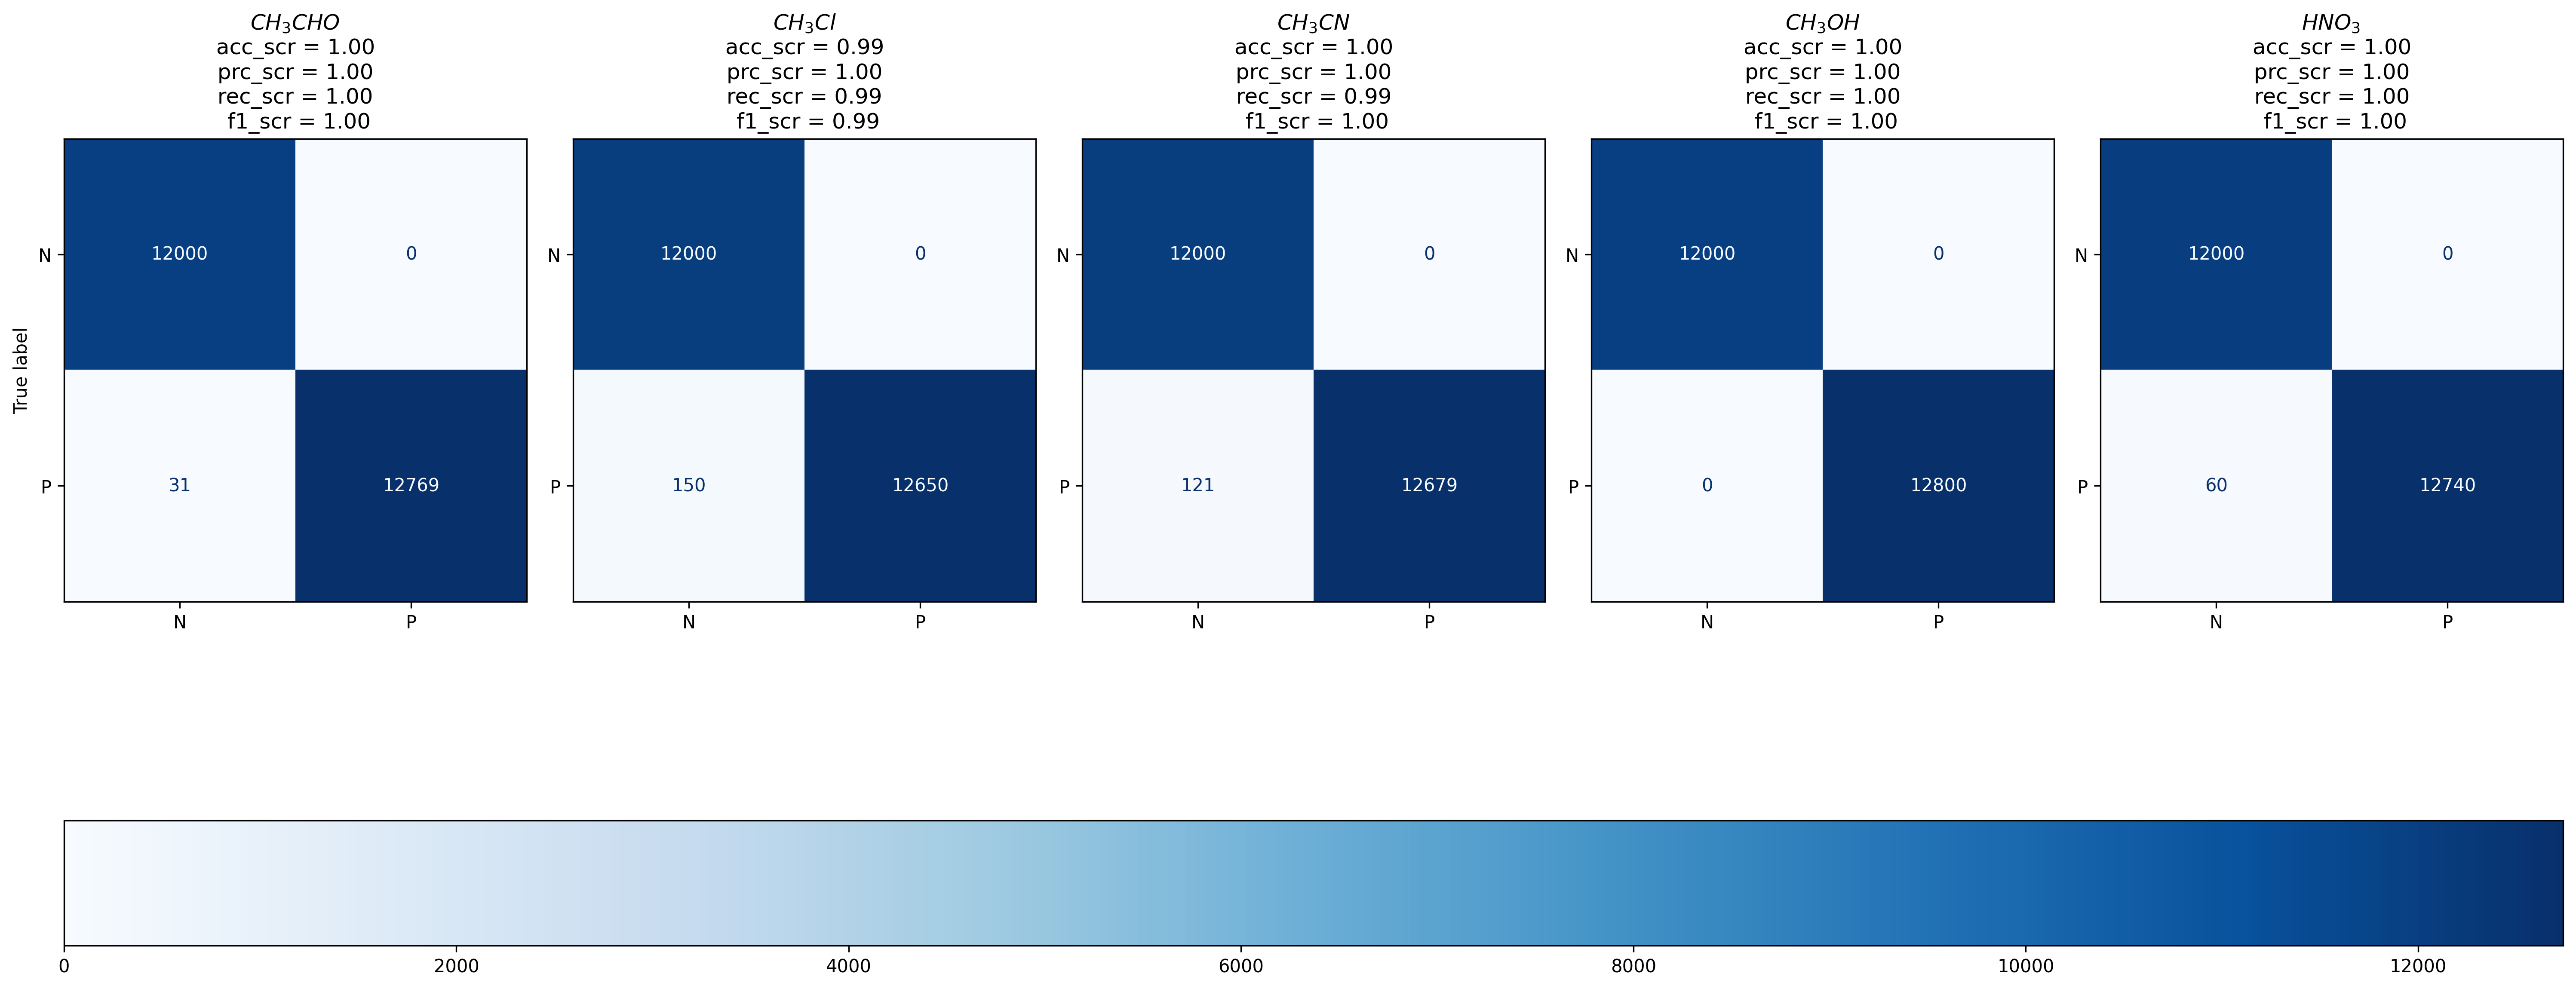

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import make_multilabel_classification
# from sklearn.tree import DecisionTreeClassifier

# X, y = make_multilabel_classification(n_samples=1000,
#                                       n_classes=15, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=42)

# tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# y_pred = tree.predict(X_test)

f, axes = plt.subplots(1, 5, figsize=(25, 15), dpi=300)
axes = axes.ravel()
for i in range(5):
    acc_scr = accuracy_score(y_val_ohe[:, i], y_pred_ohe_SVC[:, i])
    prc_scr = precision_score(y_val_ohe[:, i], y_pred_ohe_SVC[:, i])
    rec_scr = recall_score(y_val_ohe[:, i], y_pred_ohe_SVC[:, i])
    f1_scr = f1_score(y_val_ohe[:, i], y_pred_ohe_SVC[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix(y_val_ohe[:, i],
                                                   y_pred_ohe_SVC[:, i]),
                                  display_labels=['N', 'P'])

#     disp = ConfusionMatrixDisplay.from_predictions(y_val_ohe[:, i],
#                                                    y_pred_ohe[:, i], cmap = 'Blues',
#                                   display_labels=['N', 'P'])
    
    disp.plot(ax=axes[i],cmap='Blues')
#     disp.plot(ax=axes[i], values_format='.4g'
    disp.ax_.set_title(f'{reduced_labels[i]} \n acc_scr = {acc_scr:.2f} \n prc_scr = {prc_scr:.2f} \n rec_scr = {rec_scr:.2f} \n f1_scr = {f1_scr:.2f}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, orientation = 'horizontal')
plt.show()
f.savefig(r'RESULTS/multi_label_results/multilabel_cm_bin_val_SVC.png', bbox_inches='tight')

# Now at different SNR validation data

In [26]:
data_filename_T1 = "datasets/TSMCN-5-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.05_10-09-2022_time_19-52-15_SNR_30.pkl"
DV_test = pd.read_pickle(data_filename_T1)
y_T1 = DV_test['y'].to_numpy()
mixture_names = DV_test['mixture_names'].to_numpy()
y_concentrations_T1 = DV_test[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4']].to_numpy()
X_T1 = DV_test.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4'],axis=1).to_numpy()

In [27]:
y_T1_ohe = concentrations_to_one_hot_encode(y_concentrations_T1)

In [28]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices_T1=range(0, X_T1.shape[0])
print(global_indices_T1)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
TEST_SIZE=1-TRAIN_SIZE

x_train_T1, x_test_T1, y_train_T1, y_test_T1, train_indices_T1, test_indices_T1 = train_test_split(X_T1, y_T1, global_indices_T1, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                    stratify=y_T1

                                                   )

print('x_train_T1 shape:', x_train_T1.shape)
print('y_train_T1 shape:', y_train_T1.shape)

print('x_test_T1 shape:', x_test_T1.shape)
print('y_test_T1 shape:', y_test_T1.shape)


print("All:", np.bincount(y_T1) / float(len(y_T1))*100  )
print("Training:", np.bincount(y_train_T1) / float(len(y_train_T1))*100  )
print("Validation:", np.bincount(y_test_T1) / float(len(y_test_T1))*100  )


range(0, 62000)
x_train_T1 shape: (37200, 229)
y_train_T1 shape: (37200,)
x_test_T1 shape: (24800, 229)
y_test_T1 shape: (24800,)
All: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Training: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Validation: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3

In [29]:
y_train_ohe_T1 = y_concentrations_T1[train_indices_T1].astype('int64')
y_val_ohe_T1 = y_concentrations_T1[test_indices_T1].astype('int64')

In [30]:
y_pred_ohe_T1 = clf.predict(x_test_T1)
y_pred_ohe_T1_SVC = clf_SVC.predict(x_test_T1)

In [31]:
SNR_string = data_filename_T1.split('SNR')[1].split('.pkl')[0].split('_')[1]

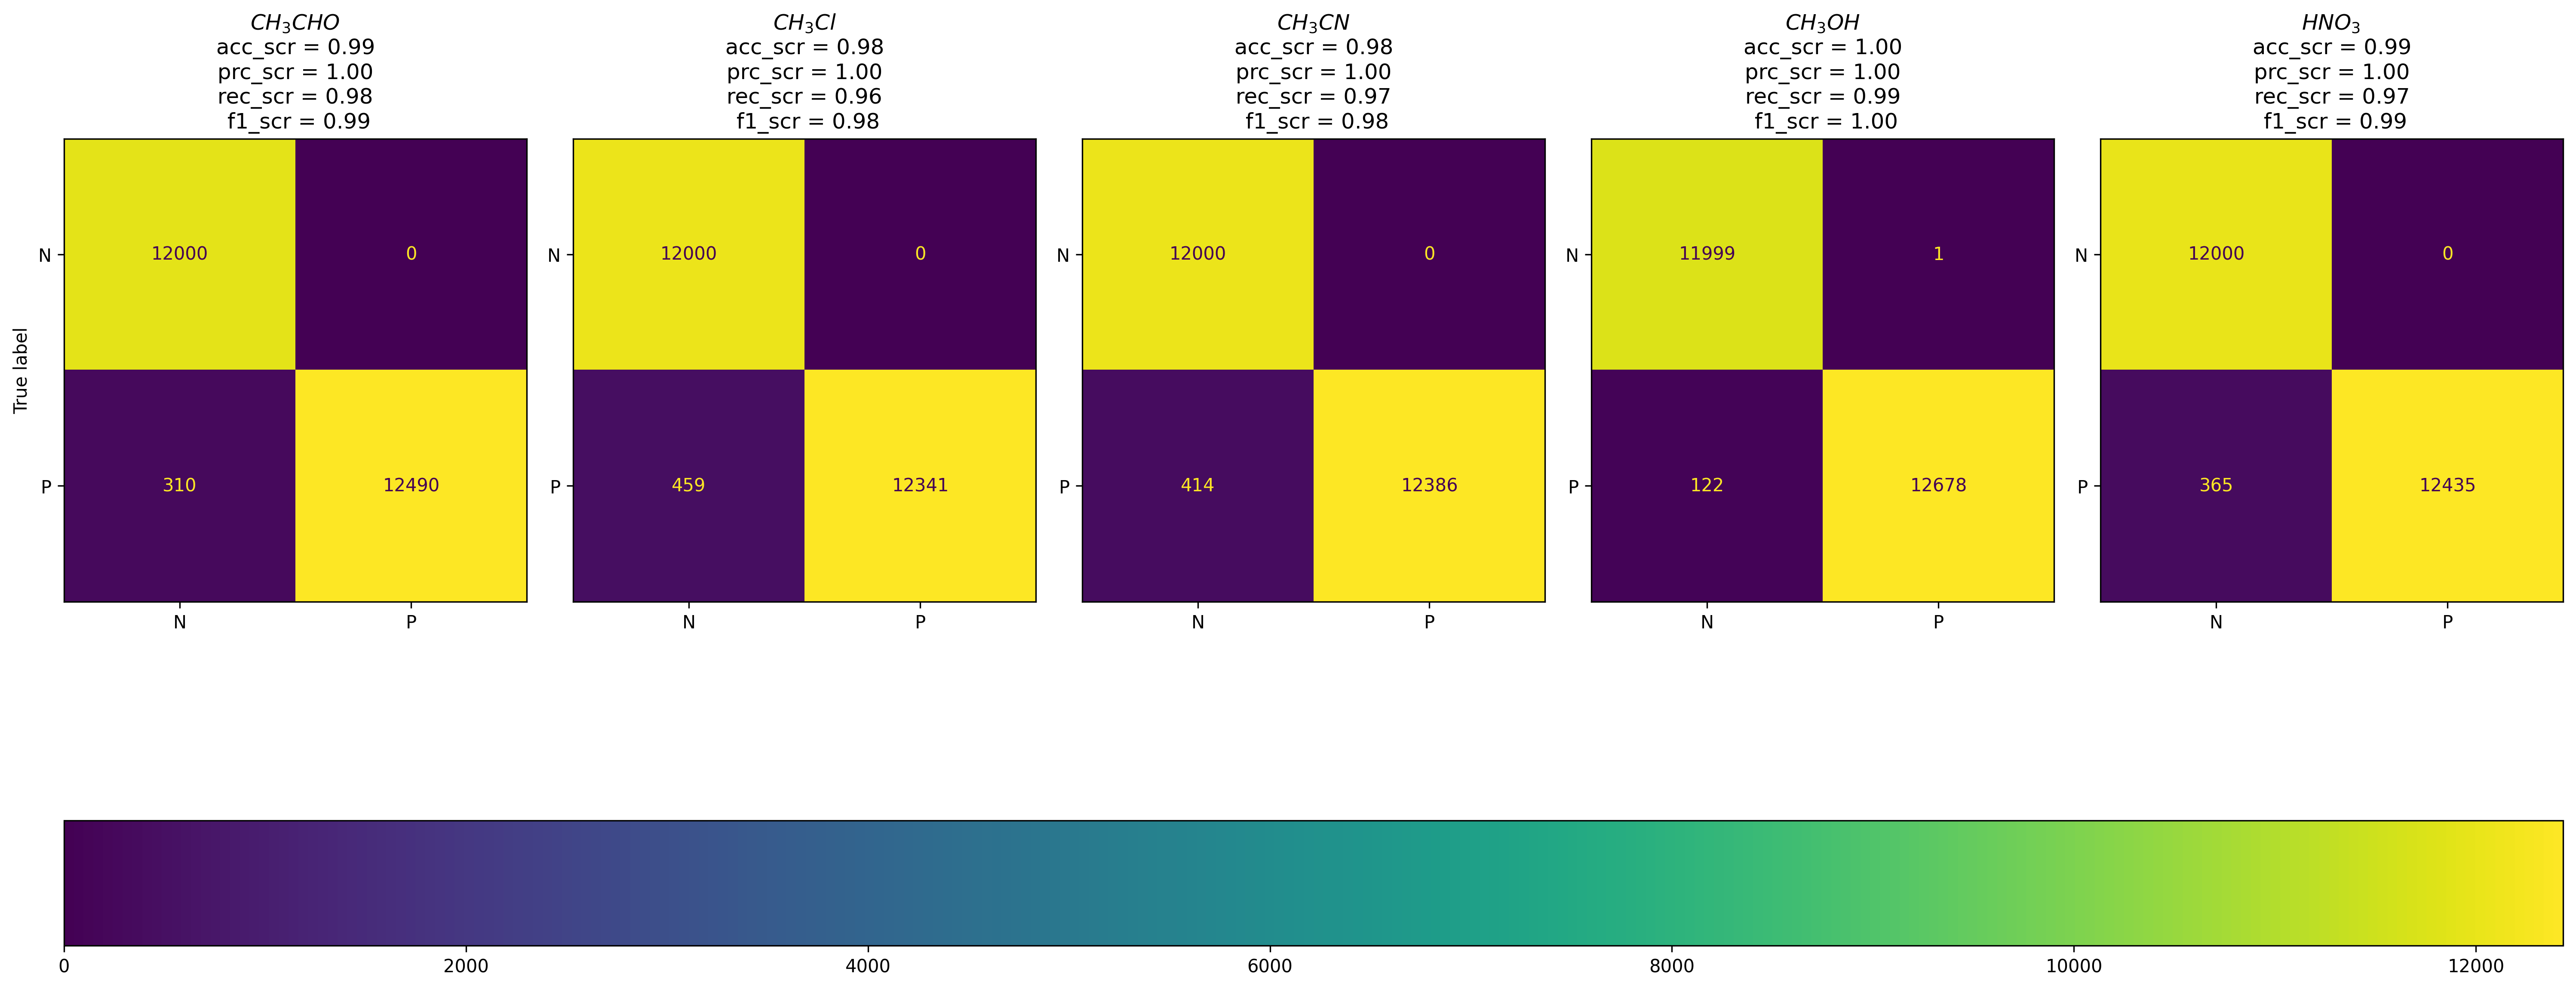

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import make_multilabel_classification
# from sklearn.tree import DecisionTreeClassifier

# X, y = make_multilabel_classification(n_samples=1000,
#                                       n_classes=15, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=42)

# tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# y_pred = tree.predict(X_test)

f, axes = plt.subplots(1, 5, figsize=(25, 15), dpi=300)
axes = axes.ravel()
for i in range(5):
    acc_scr = accuracy_score(y_val_ohe[:, i], y_pred_ohe_T1[:, i])
    prc_scr = precision_score(y_val_ohe[:, i], y_pred_ohe_T1[:, i])
    rec_scr = recall_score(y_val_ohe[:, i], y_pred_ohe_T1[:, i])
    f1_scr = f1_score(y_val_ohe[:, i], y_pred_ohe_T1[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix(y_val_ohe_T1[:, i],
                                                   y_pred_ohe_T1[:, i]),
                                  display_labels=['N', 'P'])

#     disp = ConfusionMatrixDisplay.from_predictions(y_val_ohe[:, i],
#                                                    y_pred_ohe[:, i], cmap = 'Blues',
#                                   display_labels=['N', 'P'])
    
    disp.plot(ax=axes[i])
#     disp.plot(ax=axes[i], values_format='.4g'
    disp.ax_.set_title(f'{reduced_labels[i]} \n acc_scr = {acc_scr:.2f} \n prc_scr = {prc_scr:.2f} \n rec_scr = {rec_scr:.2f} \n f1_scr = {f1_scr:.2f}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, orientation = 'horizontal')
plt.show()
f.savefig(r'RESULTS/multi_label_results/multilabel_cm_bin_test_SNR_' + SNR_string +  '.png', bbox_inches='tight')

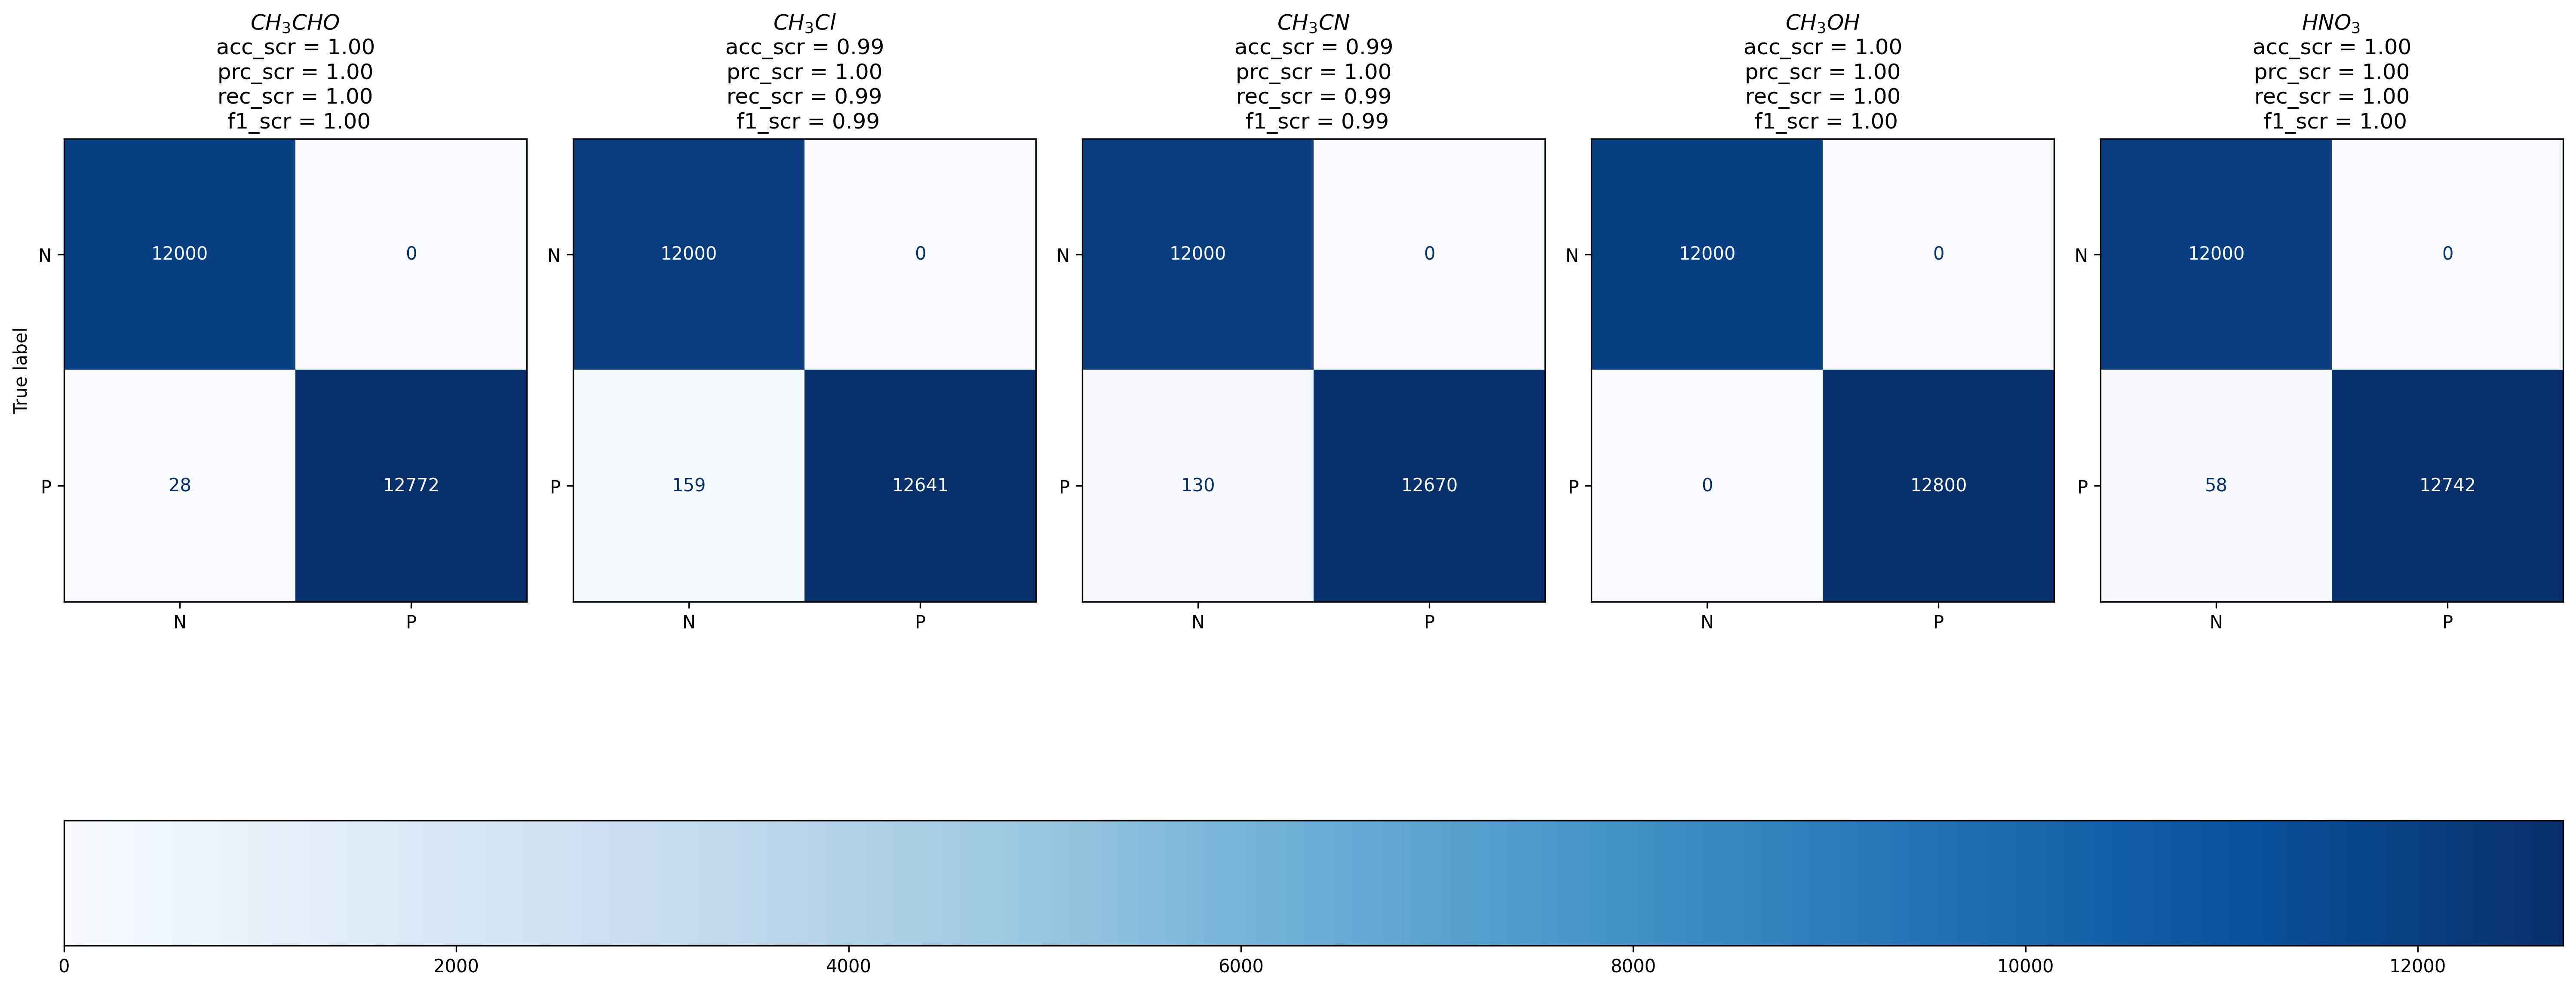

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import make_multilabel_classification
# from sklearn.tree import DecisionTreeClassifier

# X, y = make_multilabel_classification(n_samples=1000,
#                                       n_classes=15, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=42)

# tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# y_pred = tree.predict(X_test)

f, axes = plt.subplots(1, 5, figsize=(25, 15), dpi=300)
axes = axes.ravel()
for i in range(5):
    acc_scr = accuracy_score(y_val_ohe[:, i], y_pred_ohe_T1_SVC[:, i])
    prc_scr = precision_score(y_val_ohe[:, i], y_pred_ohe_T1_SVC[:, i])
    rec_scr = recall_score(y_val_ohe[:, i], y_pred_ohe_T1_SVC[:, i])
    f1_scr = f1_score(y_val_ohe[:, i], y_pred_ohe_T1_SVC[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix(y_val_ohe_T1[:, i],
                                                   y_pred_ohe_T1_SVC[:, i]),
                                  display_labels=['N', 'P'])

#     disp = ConfusionMatrixDisplay.from_predictions(y_val_ohe[:, i],
#                                                    y_pred_ohe[:, i], cmap = 'Blues',
#                                   display_labels=['N', 'P'])
    
    disp.plot(ax=axes[i],cmap='Blues')
#     disp.plot(ax=axes[i], values_format='.4g'
    disp.ax_.set_title(f'{reduced_labels[i]} \n acc_scr = {acc_scr:.2f} \n prc_scr = {prc_scr:.2f} \n rec_scr = {rec_scr:.2f} \n f1_scr = {f1_scr:.2f}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, orientation = 'horizontal')
plt.show()
f.savefig(r'RESULTS/multi_label_results/multilabel_cm_bin_test_SVC_SNR_' + SNR_string +  '.png', bbox_inches='tight')

In [34]:
# experiment classification

In [38]:

exps = ['2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 50% Dilute CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Pure Mix CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 90% Dilute CM-ACN.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 1.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 2.xlsx',
'4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx']


exp_path = '../../data/Mixture_exp_data/'
exp_filepath = '4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx'


def multilabel_classify_exp(exp_path,exp_filepath,reduced_labels):

    df_exp1 = pd.read_excel(exp_path + exp_filepath)


    freq_exp1 = df_exp1[df_exp1.columns[0]].to_numpy()
    abs_exp1 = df_exp1[df_exp1.columns[1]].to_numpy()


    dfy_resampled= signal.resample(abs_exp1, len(m.frequencies))
    dfx_resampled= signal.resample(freq_exp1, len(m.frequencies))
    # expanded_abs = np.expand_dims(np.expand_dims(dfy_resampled, axis=-1), axis=0)
    pred_exp_label = clf.predict(dfy_resampled.reshape(1,len(m.frequencies) ))

    print('Experiment name: ',exp_filepath.split('/')[0])
    print('species sequence', reduced_labels)
    print('predicted label', pred_exp_label)

    return pred_exp_label

In [39]:
for experiment in exps:
    multilabel_classify_exp(exp_path,experiment,reduced_labels)

Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 0 1]]
Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 1 1]]
Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 0 1 0 0]]
Experiment name:  3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 1 0]]
Experiment name:  3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 1 1]]
Experiment name:  4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[

In [58]:
clf.predict(dfy_resampled.reshape(1,229))

array([[0, 0, 0, 1, 0]])

In [54]:
dfy_resampled.shape

(229,)

In [57]:
reduced_labels

(1, 229, 1)

In [37]:
def multilabel_classify_exp_SVC(exp_path,exp_filepath,reduced_labels):

    df_exp1 = pd.read_excel(exp_path + exp_filepath)


    freq_exp1 = df_exp1[df_exp1.columns[0]].to_numpy()
    abs_exp1 = df_exp1[df_exp1.columns[1]].to_numpy()


    dfy_resampled= signal.resample(abs_exp1, len(m.frequencies))
    dfx_resampled= signal.resample(freq_exp1, len(m.frequencies))
    # expanded_abs = np.expand_dims(np.expand_dims(dfy_resampled, axis=-1), axis=0)
    pred_exp_label = clf_SVC.predict(dfy_resampled.reshape(1,len(m.frequencies) ))

    print('Experiment name: ',exp_filepath.split('/')[0])
    print('species sequence', reduced_labels)
    print('predicted label', pred_exp_label)

    return pred_exp_label

In [40]:
for experiment in exps:
    multilabel_classify_exp_SVC(exp_path,experiment,reduced_labels)

Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 0 1]]
Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 0 1]]
Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 0 0]]
Experiment name:  3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 1 0]]
Experiment name:  3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[0 1 1 1 1]]
Experiment name:  4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN
species sequence ['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']
predicted label [[